## Import libraries

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

import torch
from torch import Tensor
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

from PIL import Image
from tqdm import trange

## Set device

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## functions for plotting

In [3]:
def plot_train_results(train_loss: dict, val_loss: dict, train_acc: dict, val_acc: dict):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_loss.keys(), train_loss.values(), label='Train', marker='o')
    axes[0].plot(val_loss.keys(), val_loss.values(), label='Validate', marker='o')
    axes[0].set_title('Loss for epoch')
    axes[0].set_xlabel('Epoches')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(train_acc.keys(), train_acc.values(), label='Train', marker='o')
    axes[1].plot(val_acc.keys(), val_acc.values(), label='Validate', marker='o')
    axes[1].set_title('Dice Coefficient for epoch')
    axes[1].set_xlabel('Epoches')
    axes[1].set_ylabel('Dice (Coefficient)')
    axes[1].legend()

    for ax in axes:
        ax.set_xticks(list(train_loss.keys()))
    
    plt.tight_layout()
    plt.show()

def display_model(model: nn.Module, dataset: Dataset):
    model = model.to(device)
    model.eval()

    idx = torch.randint(low=0, high=len(dataset), size=(1,))

    img, mask = dataset[idx][0], dataset[idx][1]
    img: Tensor
    mask: Tensor
    
    pred_mask: Tensor = model(img.unsqueeze(dim=0).to(device))
    pred_mask = pred_mask.squeeze(dim=0).permute(1, 2, 0).cpu().detach().numpy()
    img = img.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(img, cmap='gray')
    axes[1].imshow(mask, alpha=0.5, cmap='jet')
    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(pred_mask, alpha=0.5, cmap='jet')
    
    axes[0].set_title('Image')
    axes[1].set_title('Real segmented image')
    axes[2].set_title('Model result')

    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

## Custom Dataset

### Create custom dataset for images and add annotations to images using COCO

In [4]:
class CustomBrainTumor(Dataset):
    def __init__(self, path_dir, annotation_file, transform=None):
        super().__init__()
        self.annotation_path = os.path.join(path_dir, annotation_file)
        self.coco = COCO(self.annotation_path)
        self.imgs_path = path_dir

        self.transform = transform

    def __len__(self):
        return len(self.coco.dataset['images'])

    def __getitem__(self, idx):
        img_data = self.coco.dataset['images'][idx]
        img_id = img_data['id']
        img_filename = img_data['file_name']

        img_path = os.path.join(self.imgs_path, img_filename)

        image = Image.open(img_path).convert("RGB")
        segmentation = self.coco.loadAnns(img_id)[0]['segmentation']

        mask = coco_mask.frPyObjects(segmentation, 640, 640)
        mask = coco_mask.decode(mask).astype(np.float32)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

### Load datasets using CustomBrainTumor

In [5]:
train_path = r'..\..\..\..\datasets\brain\train'
test_path = r'..\..\..\..\datasets\brain\test'
valid_path = r'..\..\..\..\datasets\brain\valid'

annotation_file = '_annotations.coco.json'

# A transformation to Tensor and resize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_dataset = CustomBrainTumor(train_path, annotation_file, transform=transform)
test_dataset = CustomBrainTumor(test_path, annotation_file, transform=transform)
valid_dataset = CustomBrainTumor(valid_path, annotation_file, transform=transform)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Get iterable objects over the dataset (batch size of 8)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [7]:
print(f'train data sample length: {len(train_dataset)}')
print(f'test data sample length: {len(test_dataset)}')
print(f'validation data sample length: {len(valid_dataset)}')

train data sample length: 1502
test data sample length: 215
validation data sample length: 429


# Phase 1

### Defining a custom U-Net with given in_channels and number of classes

In [8]:
class CustomUNet(nn.Module):
    def __init__(self, n_classes=1, in_channels=3):
        super().__init__()

        # A block to change channels only (height and width of image will not change)
        # new height = [old height - 3 + 2] + 1
        # new width = [old width - 3 + 2] + 1
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # An up pooling block for channels (will multiply height and width by 2)
        # new height = 2 * (old height - 1) + 2
        # new width = 2 * (old width - 1) + 2
        def convT_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, stride=2, kernel_size=2),
                nn.ReLU(inplace=True)
            )
        
        # Defining encoders to go deep in U-Net
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        # Bottle neck of U-Net
        self.bn = conv_block(512, 1024)

        # A pooling block which multiplies height and width by 0.5
        self.down_pooling = nn.MaxPool2d(2)

        # Up pooling blocks
        self.up1 = convT_block(1024, 512)
        self.up2 = convT_block(512, 256)
        self.up3 = convT_block(256, 128)
        self.up4 = convT_block(128, 64)

        # Defining decoders
        self.dec1 = conv_block(1024, 512)
        self.dec2 = conv_block(512, 256)
        self.dec3 = conv_block(256, 128)
        self.dec4 = conv_block(128, 64)
        
        # Last convolution layer to reconstruct images
        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Saving skip connections (for U-Net architecture)
        sc1 = self.enc1(x)
        sc2 = self.enc2(self.down_pooling(sc1))
        sc3 = self.enc3(self.down_pooling(sc2))
        sc4 = self.enc4(self.down_pooling(sc3))

        bottleneck = self.bn(self.down_pooling(sc4))

        # Up pooling and concating skip connections
        dc1 = self.up1(bottleneck)
        dc1 = torch.cat((dc1, sc4), dim=1)
        dc1 = self.dec1(dc1)

        dc2 = self.up2(dc1)
        dc2 = torch.cat((dc2, sc3), dim=1)
        dc2 = self.dec2(dc2)
        
        dc3 = self.up3(dc2)
        dc3 = torch.cat((dc3, sc2), dim=1)
        dc3 = self.dec3(dc3)

        dc4 = self.up4(dc3)
        dc4 = torch.cat((dc4, sc1), dim=1)
        dc4 = self.dec4(dc4)

        # Last convolution layer
        out = self.out(dc4)

        # Using sigmoid activation for binary classification
        return torch.sigmoid(out).to(torch.float32)

## Combined Loss class (Custom class for calculating loss and accuracy)

### Adding Dice loss to normal binary cross-entropy loss for better loss function as image segmentation task

### Dice coefficient to evaluate the accuracy of model

The Dice coefficient is defined as:

$$ \text{Dice} = \frac{2 \times |A \cap B|}{|A| + |B|} $$


### Dice loss = 1 - Dice

In [9]:
def dice_coefficient(preds: Tensor, targets: Tensor, epsilon=1e-6):
        preds = preds.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        intersection = (preds * targets).sum()

        # epsilon for prevent divide by zero
        return ((2. * intersection + epsilon) / (preds.sum() + targets.sum() + epsilon)).item()

In [10]:
class CombinedLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.bce_loss = nn.BCELoss()
        self.epsilon = epsilon

    def dice_loss(self, preds: Tensor, targets: Tensor):
        return 1 - dice_coefficient(preds, targets)

    def forward(self, preds, targets):
        # Total loss = Binary cross-entorpy + dice loss
        return self.bce_loss(preds, targets) + self.dice_loss(preds, targets)

### Train function to train the given model with given data

In [11]:
def train(model: nn.Module, train_dataloader: DataLoader, validate_dataloader: DataLoader, device, 
          lr=0.001, epoches=10, pretrained=False):
    
    model = model.to(device)

    # Binary cross-entropy loss for sigmoid outputs
    loss_fn = CombinedLoss()
    if pretrained:
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_acc = {}
    train_loss = {}
    val_acc = {}
    val_loss = {}

    for epoch in (pbar := trange(epoches)):
        acc_value_train = 0
        loss_value_train = 0
        acc_value_val = 0
        loss_value_val = 0

        model.train()
        for img, mask in train_dataloader:
            img: Tensor
            mask: Tensor
            img, mask = img.to(device), mask.to(device)
            
            logits: Tensor = model(img)
            loss: Tensor = loss_fn(logits, mask)

            # Update training loss and Dice coefficient
            loss_value_train += loss.item()
            binary_mask = (logits > 0.5).float()  # Apply post-processing
            acc_value_train += dice_coefficient(binary_mask, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            for img, mask in validate_dataloader:
                img: Tensor
                mask: Tensor
                img, mask = img.to(device), mask.to(device)

                logits: Tensor = model(img)
                loss: Tensor = loss_fn(logits, mask)

                # Update validation loss and Dice coefficient
                loss_value_val += loss.item()
                binary_mask = (logits > 0.5).float()  # Apply post-processing
                acc_value_val += dice_coefficient(binary_mask, mask)

        # Compute average training and validation loss per epoch
        train_loss[epoch + 1] = loss_value_train / len(train_dataloader)
        val_loss[epoch + 1] = loss_value_val / len(validate_dataloader)

        # Compute average training and validation Dice coefficient per epoch
        train_acc[epoch + 1] = acc_value_train / len(train_dataloader)
        val_acc[epoch + 1] = acc_value_val / len(validate_dataloader)

        pbar.set_description(
            f'Train loss {train_loss[epoch + 1]:.4f} | Validation loss {val_loss[epoch + 1]:.4f} | '
            f'Train Dice {train_acc[epoch + 1]:.4f} | Validation Dice {val_acc[epoch + 1]:.4f}'
        )

    return [train_loss, val_loss, train_acc, val_acc]

## Test function to test model on test dataset

In [12]:
def test(model: nn.Module, test_dataloader: DataLoader, device):
    model.eval()

    dice_coef = 0

    with torch.no_grad():
        for img, mask in test_dataloader:
            img: Tensor
            mask: Tensor
            img, mask = img.to(device), mask.to(device)

            logits: Tensor = model(img)
            binary_mask = (logits > 0.5).float()  # Apply post-processing
            dice_coef += dice_coefficient(binary_mask, mask)

    dice_coef = dice_coef / len(test_dataloader)
    return dice_coef

### Training model for 10 epoches

In [13]:
model_UNet = CustomUNet(n_classes=1, in_channels=3)
train_results = train(model_UNet, train_dataloader, valid_dataloader, device, lr=1e-3, epoches=10)

Train loss 0.7049 | Validation loss 0.6501 | Train Dice 0.4864 | Validation Dice 0.5569: 100%|██████████| 10/10 [13:30<00:00, 81.08s/it]


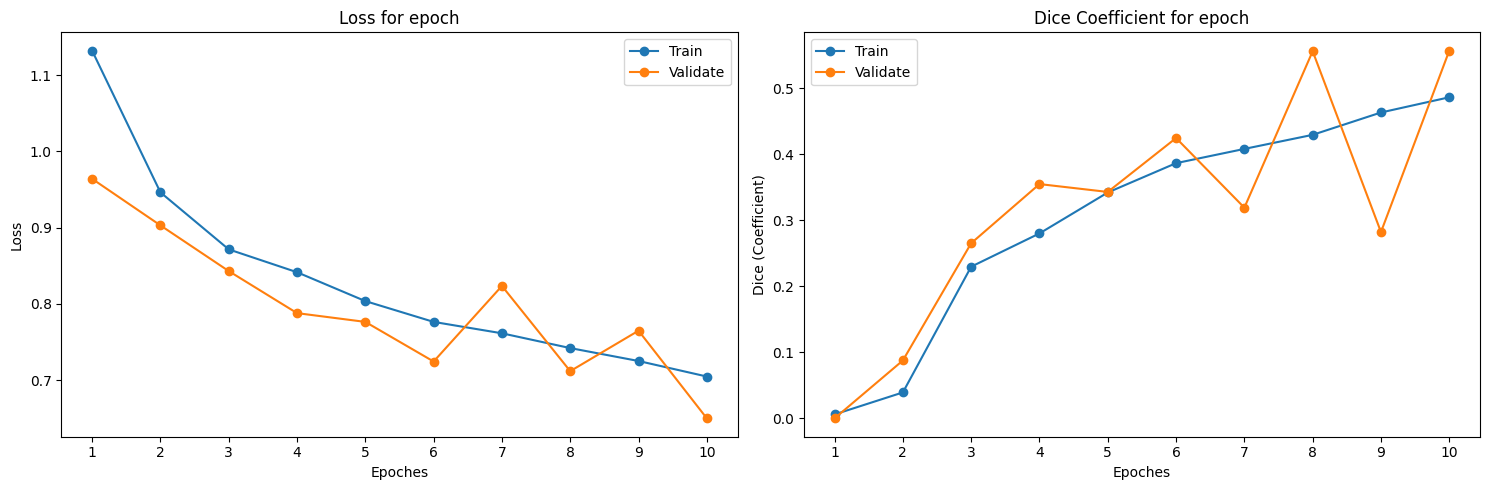

In [14]:
plot_train_results(*train_results)

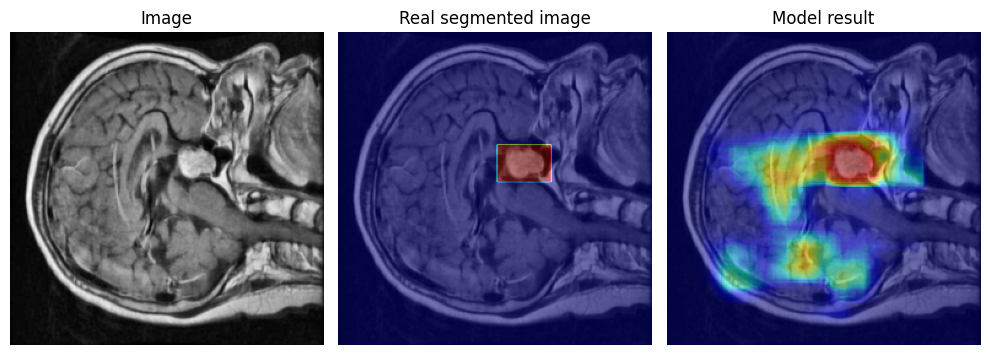

In [15]:
display_model(model_UNet, test_dataset)

In [16]:
test_dice = test(model_UNet, test_dataloader, device)
print(f'Dice Coefficient for test data {test_dice:.4f}')

Dice Coefficient for test data 0.5441


# Phase 2

### Transfer learning using segmentation_models_pytorch

In [17]:
model_attention_unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1, activation='sigmoid', decoder_attention_type='scse')

In [18]:
# Freeze the encoder layers
for param in model_attention_unet.encoder.parameters():
    param.requires_grad = False

# Unfreeze the decoder layers (to train it for segmentation)
for param in model_attention_unet.decoder.parameters():
    param.requires_grad = True

In [19]:
train_results_pretrained = train(model_attention_unet, train_dataloader, valid_dataloader, device, 
                                 lr=1e-4, epoches=10, pretrained=True)

Train loss 0.4264 | Validation loss 0.5630 | Train Dice 0.7438 | Validation Dice 0.5938: 100%|██████████| 10/10 [06:36<00:00, 39.65s/it]


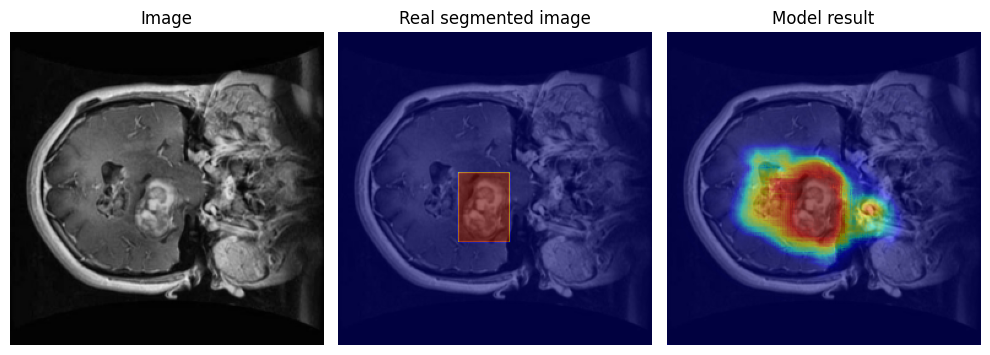

In [20]:
display_model(model_attention_unet, test_dataset)

In [21]:
test_dice = test(model_attention_unet, test_dataloader, device)
print(f'Dice Coefficient for test data {test_dice:.4f}')

Dice Coefficient for test data 0.6014
